# Rankings comparison

This tutorial provides an overview of the use of the Scikit-Criteria ranking comparison tools.

## Motivation

It is interesting to note that there are many different aggregation functions 
(TOPSIS, WeightedSum, MOORA, etc.), which summarize multiple criteria with 
quite different heuristics to a single analysis dimension; if we add to 
this the different preprocessing (scaling, weight calculation, optimality 
sense transformation, etc), the approaches to compute rankings are numerous.

The question then arises:

> What is the best approach MCDM is the best?

Or: 

> What defines that an approach is the best?

We can think of some desirable characteristics for all decision algorithms:

- Be easy to understand.
- That the representation of the problem is consistent.
- That at the minimum change of weights everything does not change abruptly.
- That any new alternative that is incorporated does not distort the ranking 
  too much.

This ends up defining a Paradox in which

> The choice of the best multi-criteria method is a multi-criteria problem.

To solve this problem we can use three different options

- Compare rankings manually.
- Exploiting the concept of inversion of the rankings.
- Sensitivity analysis.

In this tutorial we will focus on the first option.
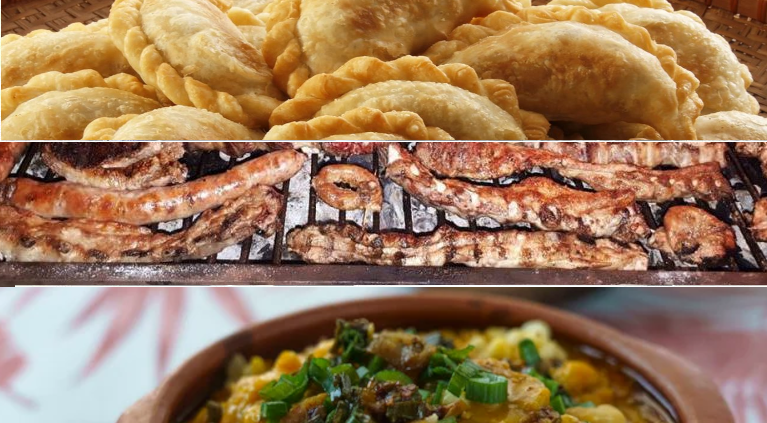

## Tools to compare rankings manually

As of *Scikit-Criteria* 0.8 there is a class and a function named
`cmp.RanksComparator` and `mkrank_cmp`, which consume multiple rankings and 
provide tools for  analysis and visualization for correlation, regression and 
direct comparison of results.

To use them we must import them from the `cmp` module.
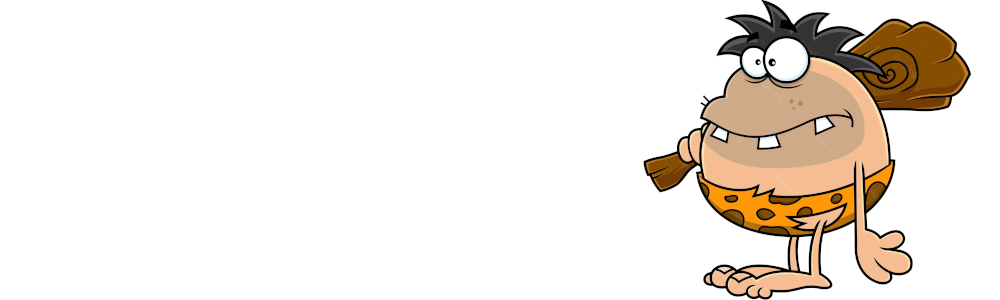

In [1]:
from skcriteria.cmp import RanksComparator, mkrank_cmp

## Experiment setup

First we need a dataset, lets use the decision-matrix extracted from from 
historical time series cryptocurrencies with `windows_size=7`.

In [2]:
import skcriteria as skc

dm = skc.datasets.load_van2021evaluation(windows_size=7)
dm

,xRV[▲ 1.0],sRV[▼ 1.0],xVV[▲ 1.0],sVV[▼ 1.0],xR2[▲ 1.0],xm[▲ 1.0]
ADA,0.029,0.156,8.144000e+09,1.586000e+10,0.312,1.821000e-11
BNB,0.033,0.167,6.141000e+09,1.118000e+10,0.396,9.167000e-09
BTC,0.015,0.097,2.095000e+11,1.388000e+11,0.281,1.254000e-08
DOGE,0.057,0.399,8.287000e+09,2.726000e+10,0.327,1.459000e-12
ETH,0.023,0.127,1.000000e+11,8.054000e+10,0.313,1.737000e-09
LINK,0.040,0.179,6.707000e+09,1.665000e+10,0.319,1.582000e-09
LTC,0.015,0.134,2.513000e+10,1.731000e+10,0.320,1.816000e-09
XLM,0.013,0.176,4.157000e+09,5.469000e+09,0.321,1.876000e-11
XRP,0.014,0.164,2.308000e+10,2.924000e+10,0.322,7.996000e-12


Now let's create three different options to evaluate our alternatives: 
One based on `WeightedSumModel`, another one based on `WeightedProductModel` 
and a final one using `TOPSIS`.

In [3]:
from skcriteria.pipeline import mkpipe
from skcriteria.preprocessing.invert_objectives import (
    InvertMinimize,
    NegateMinimize,
)
from skcriteria.preprocessing.filters import FilterNonDominated
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler
from skcriteria.agg.simple import WeightedProductModel, WeightedSumModel
from skcriteria.agg.similarity import TOPSIS

ws_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    WeightedSumModel(),
)

wp_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    WeightedProductModel(),
)

tp_pipe = mkpipe(
    NegateMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    TOPSIS(),
)

Now let's run the three options and visualize the rankings

In [4]:
wsum_result = ws_pipe.evaluate(dm)
wprod_result = wp_pipe.evaluate(dm)
tp_result = tp_pipe.evaluate(dm)

display(wsum_result, wprod_result, tp_result)

Alternatives,ADA,BNB,BTC,DOGE,ETH,LINK,LTC,XLM,XRP
Rank,8,2,1,7,3,5,6,4,9


Alternatives,ADA,BNB,BTC,DOGE,ETH,LINK,LTC,XLM,XRP
Rank,6,2,1,9,3,5,4,7,8


Alternatives,ADA,BNB,BTC,DOGE,ETH,LINK,LTC,XLM,XRP
Rank,6,2,1,8,5,3,4,7,9


### Creating a `RanksComparator` instance

There are two ways to create the ranks comparators:

1. Rither we use the `RanksComparator` class giving a sequence 
   `[[("name0", rank0), ("name1", rank1), ..., ("nameN", rankN)]`

In [5]:
RanksComparator([("ts", tp_result), ("ws", wsum_result), ("wp", wprod_result)])

<RanksComparator [ranks=['ts', 'ws', 'wp']]>

2. we let the names be inferred from the methods with the `mkrank_cmp()` function

In [6]:
rcmp = mkrank_cmp(tp_result, wsum_result, wprod_result)
rcmp

<RanksComparator [ranks=['TOPSIS', 'WeightedSumModel', 'WeightedProductModel']]>

###  `RankComparator` utilities

A set of useful statistics is provided to compare correlations, trends and 
covariances between the different rankings.

We can start by looking at the correlations

In [7]:
rcmp.corr()  # by default the pearson correlation is used


Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,1.000000,0.783333,0.916667
WeightedSumModel,0.783333,1.000000,0.816667
WeightedProductModel,0.916667,0.816667,1.000000


In [8]:
rcmp.corr(method="kendall")  # or we can us the kendal correlation

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,1.000000,0.666667,0.777778
WeightedSumModel,0.666667,1.000000,0.666667
WeightedProductModel,0.777778,0.666667,1.000000


Covariances are also available

In [9]:
rcmp.cov()

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,7.500,5.875,6.875
WeightedSumModel,5.875,7.500,6.125
WeightedProductModel,6.875,6.125,7.500


And the $R^2$ score (the same as the linear regression) between rankings

In [10]:
rcmp.r2_score()

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,1.000000,0.566667,0.833333
WeightedSumModel,0.566667,1.000000,0.633333
WeightedProductModel,0.833333,0.633333,1.000000


Another thing available is to analyze how far one ranking is from the other.

By default the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) is used, but any of the available [`scipy.spatial.distance.pdist()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) functions can be used.


In [11]:
rcmp.distance()

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,0.000000,0.666667,0.444444
WeightedSumModel,0.666667,0.000000,0.555556
WeightedProductModel,0.444444,0.555556,0.000000


In [12]:
rcmp.distance(metric="cityblock")

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,0.0,12.0,6.0
WeightedSumModel,12.0,0.0,10.0
WeightedProductModel,6.0,10.0,0.0


A distance function can also be provided

In [13]:
def my_distance(u,v,w=None):
    return 42

rcmp.distance(metric=my_distance)

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,0.0,42.0,42.0
WeightedSumModel,42.0,0.0,42.0
WeightedProductModel,42.0,42.0,0.0


Finally, if all this is insufficient, we can turn the comparator into a `pandasDataFrame`

In [14]:
rcmp.to_dataframe()

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Alternatives,,,
ADA,6,8,6
BNB,2,2,2
BTC,1,1,1
DOGE,8,7,9
ETH,5,3,3
LINK,3,5,5
LTC,4,6,4
XLM,7,4,7
XRP,9,9,8


###  `RankComparator` Plots!

The other set of analysis tools are obviously the visualization tools.

A classic in the area *Ranking flows*

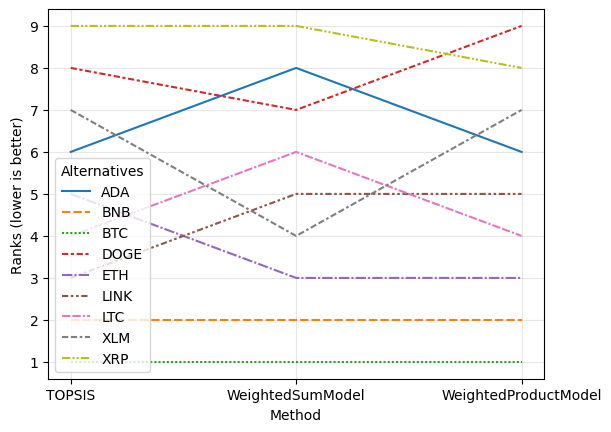

In [15]:
rcmp.plot.flow();

We can also run regressions on all combinations of different rankings.

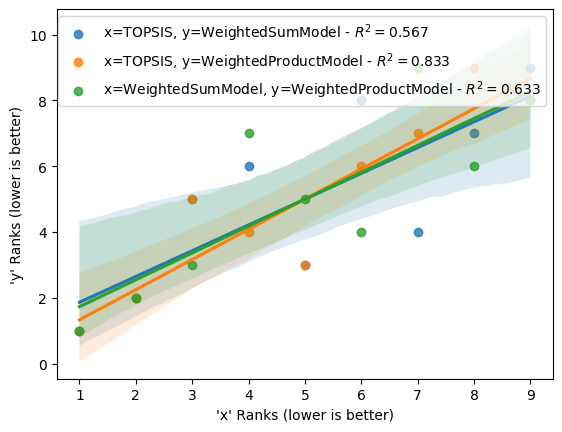

In [16]:
rcmp.plot.reg(r2=True, r2_fmt=".3f");

There are also bar plots

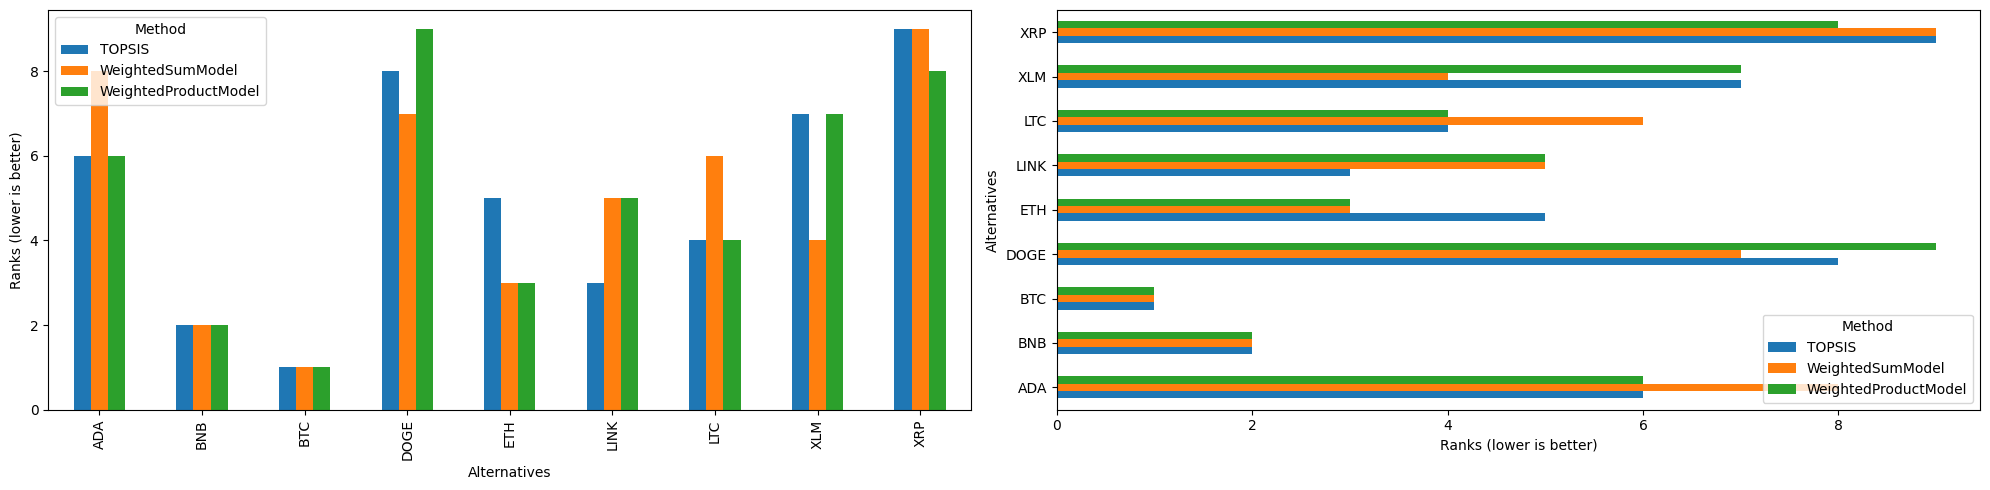

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.bar(ax=axs[0]) 
rcmp.plot.barh(ax=axs[1]) 

fig.tight_layout();

and boxplots

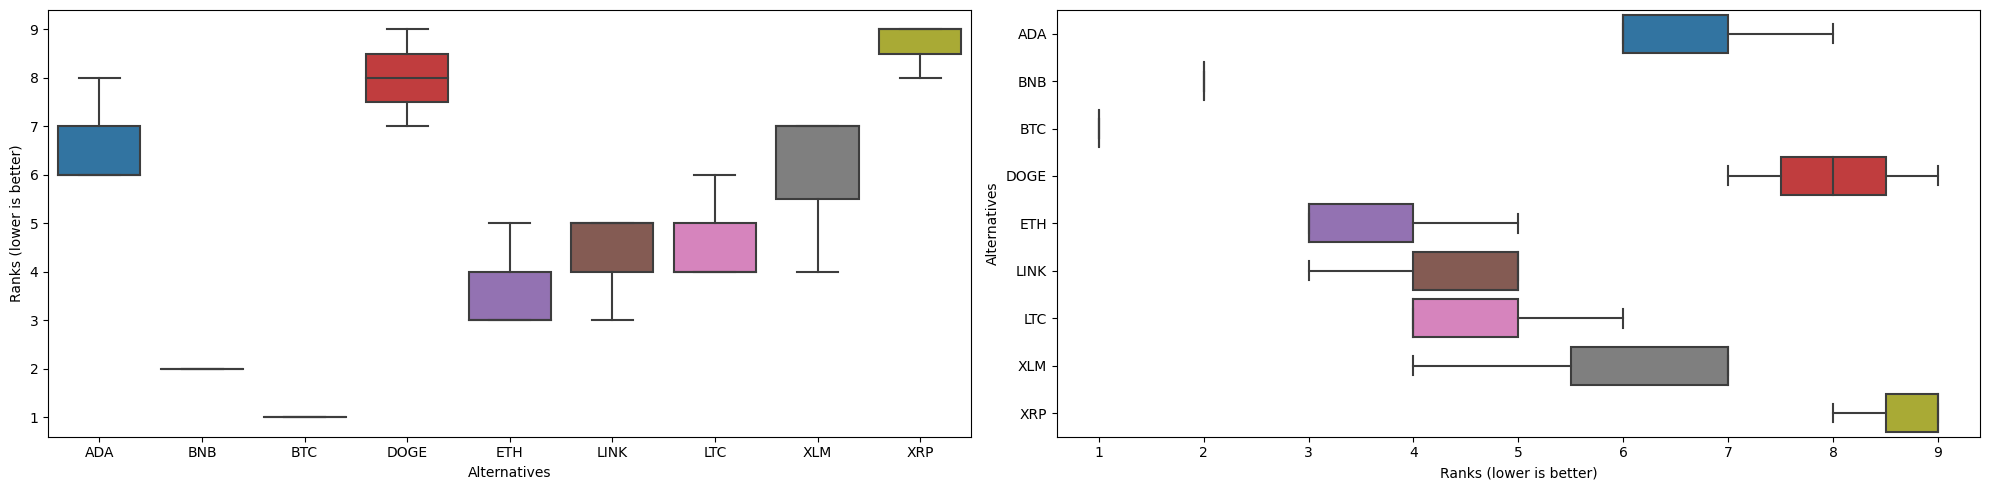

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.box(ax=axs[0]) 
rcmp.plot.box(ax=axs[1], orient="h") 

fig.tight_layout();

And you can visualize all matrices with statistical heatmap-like plots.

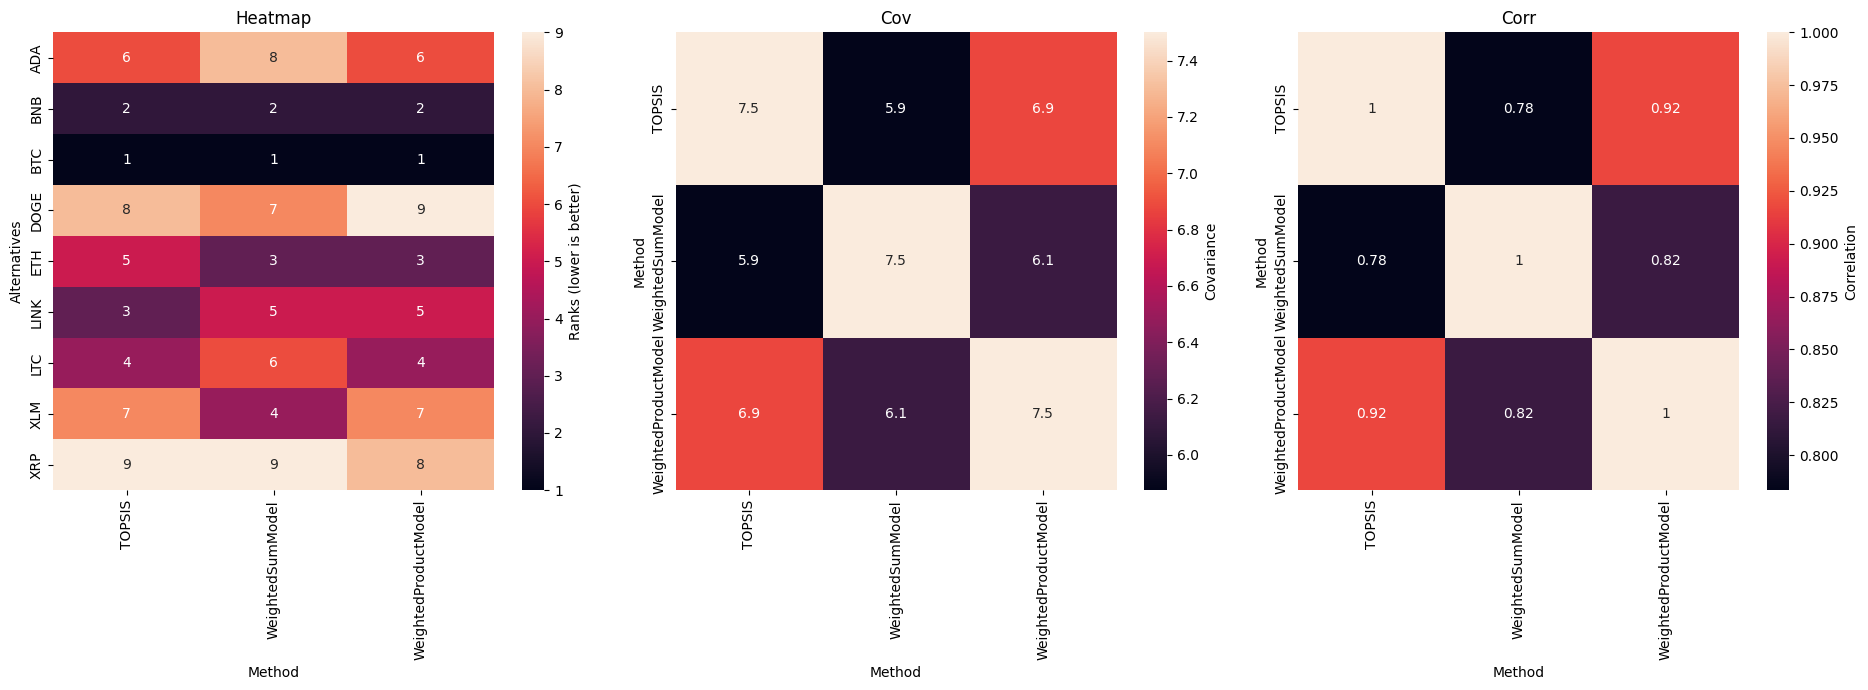

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(19, 7))

for kind, ax in zip(["heatmap", "cov", "corr"], axs):
    rcmp.plot(kind, ax=ax)
    ax.set_title(kind.title())


fig.tight_layout()

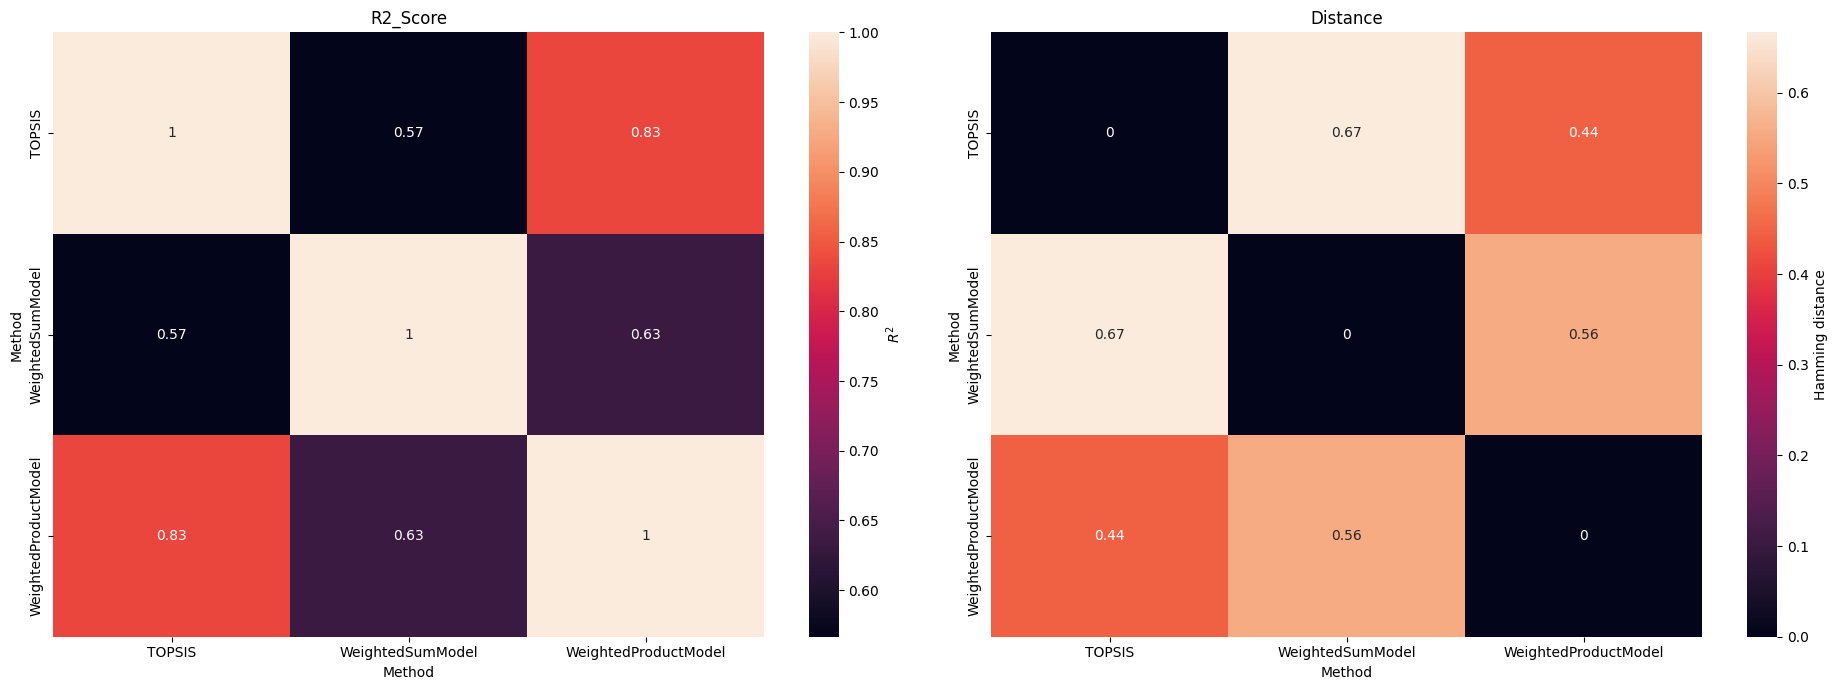

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))

for kind, ax in zip(["r2_score", "distance"], axs):
    rcmp.plot(kind, ax=ax)
    ax.set_title(kind.title())

fig.tight_layout()